# Model and Welfare Evaluation Framework

We evaluate recommendation systems by examining the welfare generated for a representative consumer. We intentionally abstract from heterogeneity and assume **one typical consumer**, allowing us to isolate the welfare implications of different recommendation-set designs.

---

## 1. Consumer Search-and-Adoption Model

For each query \(q\), the recommendation system presents an ordered list:

$$
\mathcal{R}_q = \{ d_1, d_2, \ldots, d_T \}.
$$

Each document is either **high-quality (HQ)** or **low-quality (LQ)**.  
The consumer inspects items sequentially and decides whether to adopt each document.

- If an item is adopted, the search terminates.  
- If no document is adopted, utility is **0**.

Define:

$$
H_t = \mathbf{1}\{ d_t \text{ is high quality} \}.
$$

Conditional on reaching item \(t\):

- HQ adoption probability: $P_{hq} \in (0,1)$,
- LQ adoption probability: $p_{lq}$ (a small fixed constant),assumed to be 0.1 WLOG.

Utility gain from adoption:

$$
u =
\begin{cases}
+1, & \text{if HQ adopted}, \\
-C, & \text{if LQ adopted}.
\end{cases}
$$

Let $S_{t-1}$ be the probability that no item has been adopted before position \(t\).  
Expected utility for query \(q\) is:

$$
EU(q; P_{hq}, C)
=
\sum_{t=1}^{T}
S_{t-1}\Big(
H_t P_{hq}(1)
+
(1-H_t) p_{lq}(-C)
\Big).
$$

Continuation probability:

$$
S_t
=
S_{t-1}
\big[
H_t(1-P_{hq}) + (1-H_t)(1-p_{lq})
\big],
\qquad S_0 = 1.
$$

This process is an absorbing Markov chain, yielding a closed-form expectation.

---

## 2. Welfare and the Firm's Objective

With one representative consumer and no production cost, expected utility directly measures social welfare. Under first-order price discrimination, the platform can extract all consumer surplus. Thus, expected utility measures both social welfare and the upper bound of firm profitibability.

---

## 3. Core Tradeoff: Set Size vs. Quality Risk

The key difference between **Top-K** and **Conformal Prediction** lies in set size.

### Small sets

- Lower exposure to LQ content.  
- Higher probability that the consumer **fails to find** an HQ item, especially when  
  $P_{hq}$ is small.

### Large sets

- Higher likelihood of including at least one HQ item.  
- But greater exposure to LQ content, especially harmful when  
  $C$ is large.

Hence, the model embeds a **discovery–risk tradeoff**:

$$
\text{Larger sets increase HQ discovery but raise LQ harm risk.}
$$

---

## 4. Recommendation Policies

### Top-K Ranking

Return the top $(K \in \{2,3,4,5,6\})$ items by predicted relevance:

$$
EU_{\text{Top-}K}(q; P_{hq}, C)
=
EU(\{ d_1,\ldots,d_K \}; P_{hq}, C).
$$

### Conformal Prediction Sets

A calibrated conformal method yields a variable-length prediction set:

$$
EU_{\text{Conf}}(q; P_{hq}, C)
=
EU(\mathcal{R}^{\text{Conf}}_q; P_{hq}, C).
$$

---

## 5. Comparative Evaluation

For each pair $(P_{hq}, C)$ in a grid:

$$
P_{hq} \in [0.1, 0.9], \qquad C \in [1, 10],
$$

compute:

$$
\text{OverallEU}_{\text{Top-}K}(P_{hq}, C),
\qquad
\text{OverallEU}_{\text{Conf}}(P_{hq}, C).
$$

Define their difference:

$$
\Delta(P_{hq},C)
=
\text{OverallEU}_{\text{Conf}}(P_{hq},C)
-
\text{OverallEU}_{\text{Top-}K}(P_{hq},C).
$$

Interpretation:

- If  
  $\Delta(P_{hq},C) > 0,$  
  conformal dominates Top-K.

- If  
  $\Delta(P_{hq},C) < 0,$  
  Top-K dominates conformal.

The decision boundary:

$$
\Delta(P_{hq},C) = 0
$$

divides the $(P_{hq},C)$-plane into regions where each method prevails.

### Economic Interpretation

- Higher ($C$): misinformation becomes more harmful → small sets safer → Top-K improves.
- Lower ($P_{hq}$): consumer more selective or less capable → large sets improve discovery → conformal improves.

Thus the $(P_{hq},C)$-plane reveals the **regional dominance** of the two recommendation systems.



In [32]:
import pandas as pd

df = pd.read_csv("conformal_results.csv")

def parse_list_cell(cell):
    if pd.isna(cell) or str(cell).strip() == "":
        return []
    return [x.strip() for x in str(cell).split(",") if x.strip() != ""]

df["true_high_quality_list"] = df["true_high_quality"].apply(parse_list_cell)
df["recommended_docs_list"] = df["recommended_docs"].apply(parse_list_cell)

df["true_high_quality_list"] = df["true_high_quality_list"].apply(
    lambda lst: [int(x) for x in lst]
)
df["recommended_docs_list"] = df["recommended_docs_list"].apply(
    lambda lst: [int(x) for x in lst]
)


Grid search saved at overallEU_grid_PC_conformal.csv


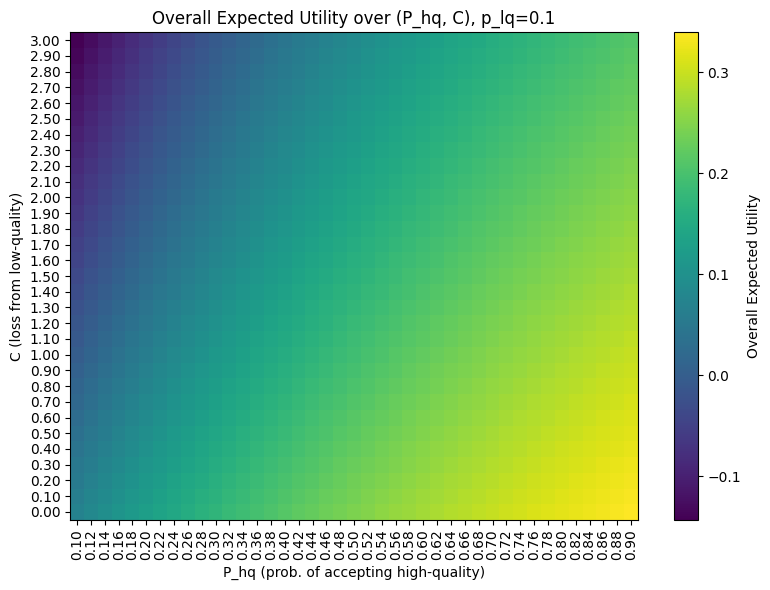

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse_list_cell(cell):
    if pd.isna(cell) or str(cell).strip() == "":
        return []
    return [int(x.strip()) for x in str(cell).split(",") if x.strip() != ""]


def load_results(csv_path="conformal_results.csv"):
    df = pd.read_csv(csv_path)
    df["true_high_quality_list"] = df["true_high_quality"].apply(parse_list_cell)
    df["recommended_docs_list"] = df["recommended_docs"].apply(parse_list_cell)
    return df

p_lq_fixed = 0.1

def expected_utility_for_list(recommended_docs, true_high_quality_set, P_hq, C, p_lq=0.1):
    """
    recommended_docs: list of doc_ids (int)
    true_high_quality_set: set of high-quality doc_ids
    P_hq: Prob of adopting a high-quality doc
    p_lq: Prob of adopting a low-quality doc (fixed at 0.1)
    C: utility loss when adopting low-quality content

    return: expected utility
    """
    S_prev = 1.0
    EU = 0.0

    for doc in recommended_docs:
        if doc in true_high_quality_set:
            EU += S_prev * P_hq * 1.0
            S_prev = S_prev * (1.0 - P_hq)
        else:
            EU += S_prev * p_lq * (-C)
            S_prev = S_prev * (1.0 - p_lq)

    return EU



def overall_expected_utility(df, P_hq, C, p_lq=0.1):
    eus = []
    for _, row in df.iterrows():
        recs = row["recommended_docs_list"]
        high_set = set(row["true_high_quality_list"])
        eu = expected_utility_for_list(recs, high_set, P_hq, C, p_lq=p_lq)
        eus.append(eu)
    return float(np.mean(eus)) if len(eus) > 0 else 0.0


def grid_search_overallEU(df,
                          P_min=0.1, P_max=0.9, P_step=0.01,
                          C_min=1.0, C_max=10.0, C_step=0.05,
                          p_lq=0.1):

    P_values = np.arange(P_min, P_max + 1e-9, P_step)  # +1e-9 保证包含上界
    C_values = np.arange(C_min, C_max + 1e-9, C_step)

    rows = []
    for P_hq in P_values:
        for C in C_values:
            overallEU = overall_expected_utility(df, P_hq, C, p_lq=p_lq)
            rows.append({"P_hq": P_hq, "C": C, "overallEU": overallEU})

    res_df = pd.DataFrame(rows)
    return res_df



res_grid = grid_search_overallEU(df,
                                 P_min=0.1, P_max=0.9, P_step=0.02,
                                 C_min=0, C_max=3, C_step=0.1,
                                 p_lq=p_lq_fixed)

res_grid.to_csv("overallEU_grid_PC_conformal.csv", index=False)
print("Grid search saved at overallEU_grid_PC_conformal.csv")


pivot = res_grid.pivot(index="C", columns="P_hq", values="overallEU")

plt.figure(figsize=(8, 6))
plt.imshow(pivot.values,
           aspect="auto",
           origin="lower")
plt.colorbar(label="Overall Expected Utility")
plt.xticks(
    ticks=np.arange(len(pivot.columns)),
    labels=[f"{p:.2f}" for p in pivot.columns],
    rotation=90
)
plt.yticks(
    ticks=np.arange(len(pivot.index)),
    labels=[f"{c:.2f}" for c in pivot.index]
)
plt.xlabel("P_hq (prob. of accepting high-quality)")
plt.ylabel("C (loss from low-quality)")
plt.title(f"Overall Expected Utility over (P_hq, C), p_lq={p_lq_fixed}")
plt.tight_layout()
plt.show()



Saved!


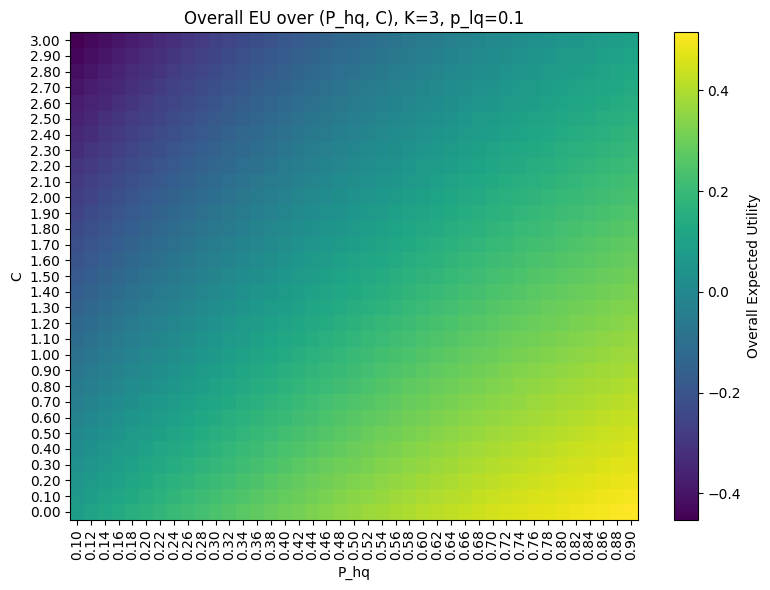

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df_raw = pd.read_csv("subset_predictions.csv")

qid_info = {}
for qid, grp in df_raw.groupby("qid"):
    grp_sorted = grp.sort_values("pred_score", ascending=False)
    sorted_docs = grp_sorted["doc_id"].tolist()
    high_quality_set = set(grp.loc[grp["label"].isin([3, 4]), "doc_id"].tolist())

    qid_info[qid] = {
        "sorted_docs": sorted_docs,
        "high_quality_set": high_quality_set
    }


def expected_utility_for_list(docs_prefix, high_set, P_hq, C, p_lq=0.1):
    S_prev = 1.0
    EU = 0.0
    for doc in docs_prefix:
        if doc in high_set:
            EU += S_prev * P_hq
            S_prev = S_prev * (1 - P_hq)
        else:
            EU += S_prev * p_lq * (-C)
            S_prev = S_prev * (1 - p_lq)
    return EU


def overall_expected_utility_for_K(qid_info, K, P_hq, C, p_lq=0.1):
    eus = []
    for qid, info in qid_info.items():
        docs = info["sorted_docs"][:K]
        high_set = info["high_quality_set"]
        eus.append(expected_utility_for_list(docs, high_set, P_hq, C, p_lq=p_lq))
    return np.mean(eus)


def grid_search_overallEU_topk(
    qid_info,
    Ks=(2, 3, 4, 5, 6),
    P_min=0.1, P_max=0.9, P_step=0.01,
    C_min=1.0, C_max=10.0, C_step=0.05,
    p_lq=0.1
):
    P_values = np.arange(P_min, P_max + 1e-9, P_step)
    C_values = np.arange(C_min, C_max + 1e-9, C_step)

    rows = []
    for K in Ks:
        for P_hq in P_values:
            for C in C_values:
                overallEU = overall_expected_utility_for_K(qid_info, K, P_hq, C, p_lq=p_lq)
                rows.append({
                    "K": K,
                    "P_hq": P_hq,
                    "C": C,
                    "overallEU": overallEU
                })

    res_df = pd.DataFrame(rows)
    return res_df


# ---------------------------

p_lq_fixed = 0.1

Ks = (2, 3, 4, 5, 6)
res_grid = grid_search_overallEU_topk(
    qid_info,
    Ks=Ks,
    P_min=0.1, P_max=0.9, P_step=0.02,
    C_min=0, C_max=3, C_step=0.1,
    p_lq=p_lq_fixed
)

res_grid.to_csv("overallEU_grid_topk_subset_predictions.csv", index=False)
print("Saved!")

K_plot = 3
df_K = res_grid[res_grid["K"] == K_plot]
pivot = df_K.pivot(index="C", columns="P_hq", values="overallEU")

plt.figure(figsize=(8, 6))
plt.imshow(pivot.values, aspect="auto", origin="lower")
plt.colorbar(label="Overall Expected Utility")
plt.xticks(ticks=np.arange(len(pivot.columns)), labels=[f"{p:.2f}" for p in pivot.columns], rotation=90)
plt.yticks(ticks=np.arange(len(pivot.index)), labels=[f"{c:.2f}" for c in pivot.index])
plt.xlabel("P_hq")
plt.ylabel("C")
plt.title(f"Overall EU over (P_hq, C), K={K_plot}, p_lq={p_lq_fixed}")
plt.tight_layout()
plt.show()


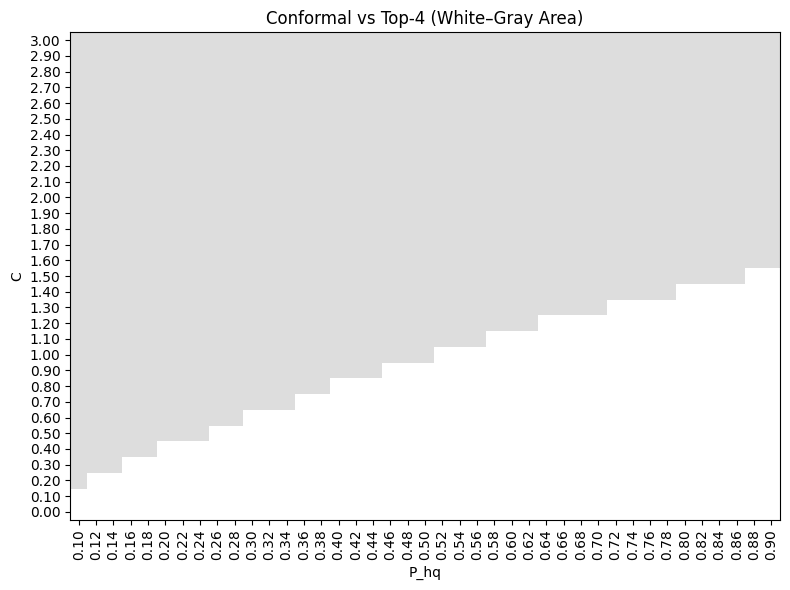

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_conf = pd.read_csv("overallEU_grid_PC_conformal.csv")
df_topk = pd.read_csv("overallEU_grid_topk_subset_predictions.csv")

K = 4
df_topk_K = df_topk[df_topk["K"] == K].copy()

df_merge = pd.merge(
    df_conf,
    df_topk_K,
    on=["P_hq", "C"],
    suffixes=("_conf", f"_top{K}")
)

df_merge["conf_better"] = df_merge["overallEU_conf"] > df_merge[f"overallEU_top{K}"]


import matplotlib.pyplot as plt
import numpy as np

pivot = df_merge.pivot(index="C", columns="P_hq", values="conf_better")
mat = pivot.values.astype(int)

import matplotlib.colors as mcolors
colors = ["#FFFFFF", "#DDDDDD"]
cmap = mcolors.LinearSegmentedColormap.from_list("white_gray", colors)

plt.figure(figsize=(8, 6))

plt.imshow(
    mat,
    aspect="auto",
    origin="lower",
    cmap=cmap,
    vmin=0, vmax=1
)

plt.xticks(
    ticks=np.arange(len(pivot.columns)),
    labels=[f"{p:.2f}" for p in pivot.columns],
    rotation=90
)
plt.yticks(
    ticks=np.arange(len(pivot.index)),
    labels=[f"{c:.2f}" for c in pivot.index]
)

plt.xlabel("P_hq")
plt.ylabel("C")
plt.title(f"Conformal vs Top-{K} (White–Gray Area)")
plt.tight_layout()
plt.show()

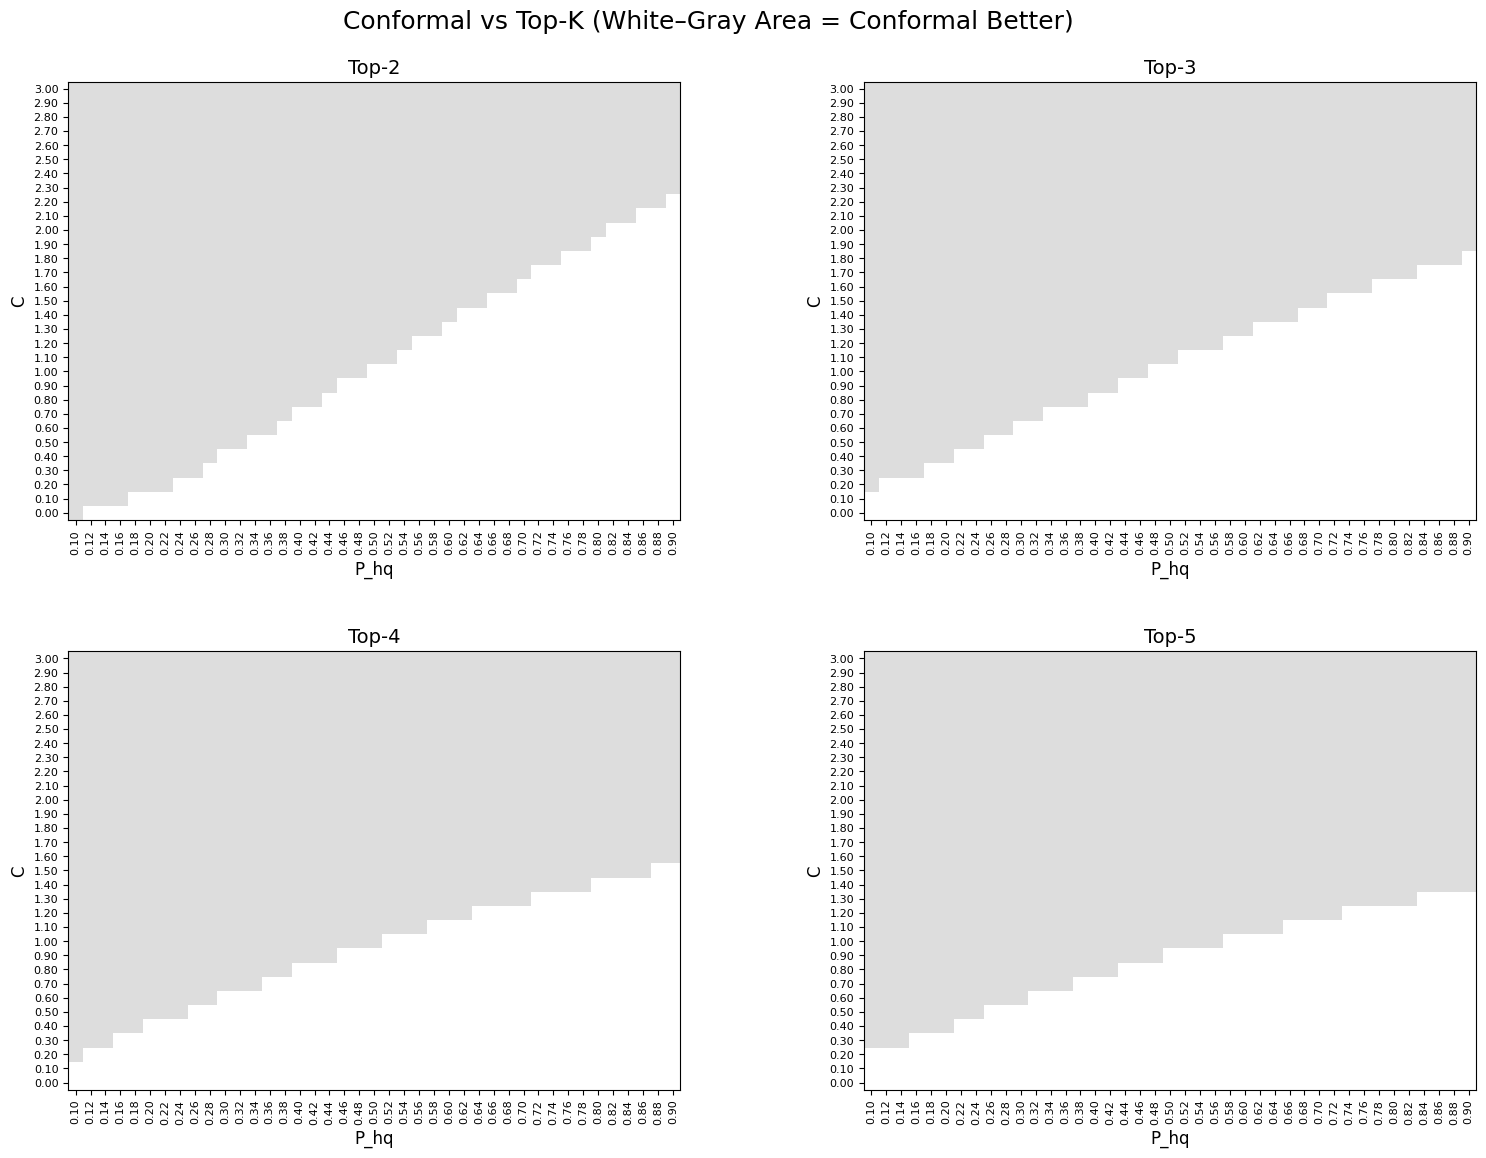

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

colors = ["#FFFFFF", "#DDDDDD"]  # 0 -> 白, 1 -> 浅灰
cmap = mcolors.LinearSegmentedColormap.from_list("white_gray", colors)

Ks = [2, 3, 4, 5]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

x_vals = None
y_vals = None

for idx, K in enumerate(Ks):
    ax = axes.flat[idx]

    df_topk_K = df_topk[df_topk["K"] == K].copy()

    df_merge = pd.merge(
        df_conf,
        df_topk_K,
        on=["P_hq", "C"],
        suffixes=("_conf", f"_top{K}")
    )

    df_merge["conf_better"] = df_merge["overallEU_conf"] > df_merge[f"overallEU_top{K}"]

    pivot = df_merge.pivot(index="C", columns="P_hq", values="conf_better")
    pivot = pivot.sort_index().sort_index(axis=1)

    if x_vals is None:
        x_vals = pivot.columns
        y_vals = pivot.index
    else:
        pivot = pivot.reindex(index=y_vals, columns=x_vals)

    mat = pivot.fillna(False).values.astype(int)

    ax.imshow(
        mat,
        aspect="auto",
        origin="lower",
        cmap=cmap,
        vmin=0, vmax=1
    )

    ax.set_title(f"Top-{K}", fontsize=14)

    ax.set_xticks(np.arange(len(x_vals)))
    ax.set_xticklabels([f"{p:.2f}" for p in x_vals], rotation=90, fontsize=8)

    ax.set_yticks(np.arange(len(y_vals)))
    ax.set_yticklabels([f"{c:.2f}" for c in y_vals], fontsize=8)

    ax.set_xlabel("P_hq", fontsize=12)
    ax.set_ylabel("C", fontsize=12)

fig.suptitle("Conformal vs Top-K (White–Gray Area = Conformal Better)", fontsize=18)

plt.subplots_adjust(
    left=0.10,
    right=0.98,
    bottom=0.08,
    top=0.92,
    wspace=0.30,
    hspace=0.30
)

plt.savefig("comparison.png", dpi=800, bbox_inches='tight')
plt.show()



## Conclusion
The comparison reveals a clear structural pattern in how the relative performance of conformal prediction versus Top-K depends on the consumer’s behavioral parameters $P_{hq}$ and $C$. When the harm from low-quality content is negligible (i.e., $C \approx 0$), the consumer effectively focuses only on maximizing the chance of encountering a high-quality item. In this region, Top-K dominates for most values of $K$ because its smaller and more precision-oriented recommendation set exposes the consumer to fewer irrelevant items and facilitates quicker adoption. An exception is $K = 2$, where the Top-2 set is sufficiently restrictive that it may exclude the high-quality content altogether, allowing conformal prediction to perform slightly better in the lower-left region of the parameter space.

As $C$ increases, however, the cost of exposing consumers to low-quality content becomes more severe, making false discoveries increasingly harmful. Under these conditions, the FDR-controlled conformal method becomes substantially more advantageous, dominating larger regions of the $(P_{hq}, C)$ plane. A similar shift occurs as $P_{hq}$ decreases: when consumers are less able to recognize high-quality information or are more cautious and tend to review the entire recommended list, the relative risk of low-quality exposure rises, again favoring conformal prediction.

Overall, the patterns indicate that conformal prediction is particularly valuable when  
(1) misinformation is highly harmful (high $C$),  
(2) consumers have limited ability to identify high-quality content (low $P_{hq}$), or  
(3) consumers exhibit patient and exhaustive search behavior.  

These conditions naturally arise in domains such as medical or financial advice, where both the stakes of misinformation and the difficulty of quality assessment are high.


In [42]:
!zip -r project.zip /content
from google.colab import files
files.download("project.zip")

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/.last_update_check.json (deflated 23%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.11.20/ (stored 0%)
  adding: content/.config/logs/2025.11.20/14.30.45.937471.log (deflated 56%)
  adding: content/.config/logs/2025.11.20/14.30.35.382199.log (deflated 87%)
  adding: content/.config/logs/2025.11.20/14.30.45.231815.log (deflated 57%)
  adding: content/.config/logs/2025.11.20/14.30.04.285207.log (deflated 93%)
  adding: content/.config/logs/2025.11.20/14.30.36.623222.log (deflated 58%)
  adding: content/.config/logs/2025.11.20/14.30.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>